In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [3]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from IPython.display import Image, display

import corner

import datetime

import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation

%matplotlib inline

In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [5]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    bulge = HernquistPotential(
                a=a_HB,
                normalize=n_HB)
    return [disk,halo,bulge]
    #return [disk,halo]

Action evolution parameters
---

- IDlist (somehow.... find where dwarf (67 für den Anfangs) merges)
- startnr
- fit routine = emcxee 1 (in v0.1; more maybe in v0.2)
- delta fix or calculation
- figure (with labels, range, title etc predefined)
- in v0.2 possibility for wrong potential


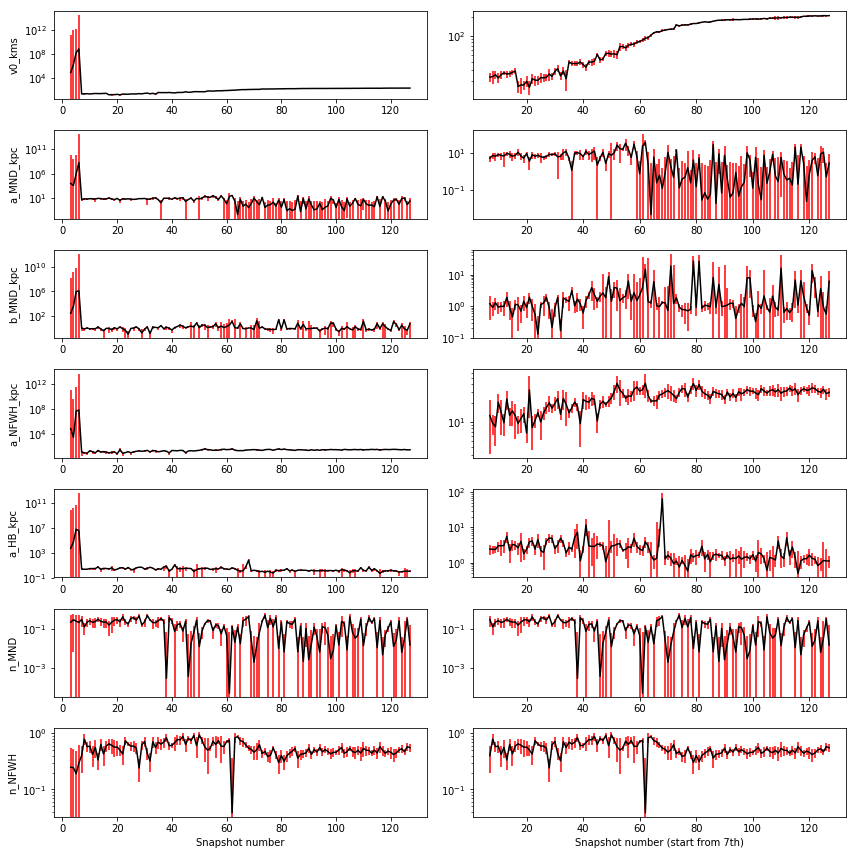

In [7]:
pot_params = np.loadtxt(filedir + 'potential_params_new.txt')
# wenn dann das file richtig ist funktioniert folgendes (hoffentlich):

snapnr          = pot_params[:,0]
v0_kms          = pot_params[:,1]
v0_kms_err      = pot_params[:,2]
a_MND_kpc       = pot_params[:,3]
a_MND_kpc_err   = pot_params[:,4]
b_MND_kpc       = pot_params[:,5]
b_MND_kpc_err   = pot_params[:,6]
a_NFWH_kpc      = pot_params[:,7]
a_NFWH_kpc_err  = pot_params[:,8]
a_HB_kpc        = pot_params[:,9]
a_HB_kpc_err    = pot_params[:,10]
n_MND           = pot_params[:,11]
n_MND_err       = pot_params[:,12]
n_NFWH          = pot_params[:,13]
n_NFWH_err      = pot_params[:,14]
n_HB            = pot_params[:,15]
n_HB_err        = pot_params[:,16]

snapnr = np.array(snapnr, dtype = int)



ndim = 7
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]

f, axes = plt.subplots(7, 2, figsize=(12,12))

params = np.vstack([v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB])
params_err = np.vstack([v0_kms_err, a_MND_kpc_err, b_MND_kpc_err, a_NFWH_kpc_err, a_HB_kpc_err, n_MND_err, n_NFWH_err, n_HB_err])
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,0].set_xlabel('Snapshot number')
    axes[ii,0].set_ylabel(labels[ii])
    axes[ii,0].errorbar(snapnr, params[ii],yerr= params_err[ii], color='k', ecolor='r')    
    axes[ii,0].set_yscale('log', nonposy="clip")
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,1].set_xlabel('Snapshot number (start from 7th)')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii,1].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
    axes[ii,1].set_yscale('log', nonposy="clip")
f.tight_layout()
f.savefig(plotdir + 'parameter_evolution_1000steps.png', dpi = 300, bbox_inches = 'tight', format = 'png')

In [11]:
# spatial evolution of merged stars from snapshot 73
level = 4
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(73,74,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        #print("snappath: {0}\n".format(snappath))
        s1, sf1 = eat_snap_and_fof(level, halo_number, snapnr-1, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        
        s2, sf2 = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 )
        s2.data['gmet'] = np.maximum( s2.data['gmet'], 1e-40 )
        
        # get positions and velocities of all stars 
        istars1, = np.where( (s1.type == 4) & (s1.halo == 0) )#& (s.subhalo == 0))
        (x1_kpc, y1_kpc, z1_kpc), (vx1_kms, vy1_kms, vz1_kms), rxyz1_kpc, rxy1_kpc = get_cartesian_vectors(s1, sf1, istars1)
        istars2, = np.where( (s2.type == 4) & (s2.halo == 0) )#& (s.subhalo == 0))
        (x2_kpc, y2_kpc, z2_kpc), (vx2_kms, vy2_kms, vz2_kms), rxyz2_kpc, rxy2_kpc = get_cartesian_vectors(s2, sf2, istars2)
 
        # mask for stars in first snapshot in first subhalo
        istarssub1, = np.where( (s1.type == 4) & (s1.halo == 0) & (s1.subhalo == 1) )
        # get their IDs
        ids_halo1 = s1.id[istarssub1]
        # check which of these stars are in the main galaxy in the snapshot after
        idsmergermask = np.isin(s2.id[np.where(s2.subhalo ==0)], ids_halo1)
        #print(np.sum(idsmergermask))
        # get their IDs
        ids_merger = s2.id[np.where(s2.subhalo ==0)][idsmergermask]        
        # create masks for merged stars according to their IDs to get their positions
        #i_snap1 = np.isin(s1.id, ids_merger)
        #i_snap2 = np.isin(s2.id, ids_merger)
        #(x1_merg_kpc, y1_merg_kpc, z1_merg_kpc), (vx1_merg_kms, vy1_merg_kms, vz1_merg_kms), rxyz1_merg_kpc, rxy1_merg_kpc = get_cartesian_vectors(s1, sf1, i_snap1)
        #(x2_merg_kpc, y2_merg_kpc, z2_merg_kpc), (vx2_merg_kms, vy2_merg_kms, vz2_merg_kms), rxyz2_merg_kpc, rxy2_merg_kpc = get_cartesian_vectors(s2, sf2, i_snap2)
        

x_mergers, y_mergers, z_mergers, R_mergers, Galrads, snapnrs = [],[],[],[],[],[]
startnr = 73
endnr = 128
nrsnapshots = int(endnr-startnr)
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startnr,endnr,1):
        snapnrs.append(snapnr)
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        #print("snappath: {0}\n".format(snappath))
        s1, sf1 = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        
        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 ) 
  
        # create masks for merged stars according to their IDs to get their positions
        i_snap1 = np.isin(s1.id, ids_merger)
        (x1_merg_kpc, y1_merg_kpc, z1_merg_kpc), (vx1_merg_kms, vy1_merg_kms, vz1_merg_kms), rxyz1_merg_kpc, rxy1_merg_kpc = get_cartesian_vectors(s1, sf1, i_snap1)
        x_mergers.append(x1_merg_kpc)
        y_mergers.append(y1_merg_kpc)
        z_mergers.append(z1_merg_kpc)
        R_mergers.append(rxy1_merg_kpc)
        Galrads.append(s1.galrad)
        #percentageofdwarf = np.sum(idsmergermask) / len(istarssub1) 
'''        
        cmap = copy.copy(plt.cm.inferno)
        cmap.set_bad((0,0,0))  # Fill background with black
        
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.2)
        #fig.colorbar(h[3], cax=cax)
        binnum = 401
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        h1 = ax1.hist2d(x1_merg_kpc, y1_merg_kpc, bins=binnum, norm=matplotlib.colors.LogNorm(), cmap = cmap)
        h2 = ax2.hist2d(rxy1_merg_kpc, z1_merg_kpc, bins=binnum, norm=matplotlib.colors.LogNorm(), cmap = cmap)
        circle1 = plt.Circle((0,0), 2000. * s1.galrad, fill = False, color = 'g')
        circle2 = plt.Circle((0,0), 2000. * s1.galrad, fill = False, color = 'g')
        ax1.add_artist(circle1)
        ax1.set_xlabel("x [kpc]")
        ax1.set_ylabel("y [kpc]")
        ax1.set_aspect('equal')
        ax1.set_title('Snapshot ' + str(snapnr))
        ax2.add_artist(circle2)
        ax2.set_xlabel("R [kpc]")
        ax2.set_ylabel("z [kpc]")
        ax2.set_aspect('equal')
        cbar2 = fig.colorbar(h2[3], ax = ax2 )
        fig.tight_layout()
'''
      


snapnr  : 73
21:13:30.704787
[ 15.1824646   14.63997269  15.67546272]
Found 536367 stars.
Rotated pos.
Rotated vel.
[ 15.47813797  14.92653275  15.98590374]
Found 667800 stars.
Rotated pos.
Rotated vel.
snapnr  : 73
21:13:40.303862
[ 15.47813797  14.92653275  15.98590374]
Found 667800 stars.
Rotated pos.
Rotated vel.
snapnr  : 74
21:13:45.394510
[ 15.85394859  15.28774834  16.39402962]
Found 754347 stars.
Rotated pos.
Rotated vel.
snapnr  : 75
21:13:50.991955
[ 16.16160011  15.58262157  16.72860718]
Found 788548 stars.
Rotated pos.
Rotated vel.
snapnr  : 76
21:13:56.611642
[ 16.47659492  15.88422775  17.06827354]
Found 817842 stars.
Rotated pos.
Rotated vel.
snapnr  : 77
21:14:02.178267
[ 16.79800034  16.19346237  17.41295624]
Found 827454 stars.
Rotated pos.
Rotated vel.
snapnr  : 78
21:14:07.854071
[ 17.20534706  16.5902729   17.85304451]
Found 863745 stars.
Rotated pos.
Rotated vel.
snapnr  : 79
21:14:13.460837
[ 17.53638649  16.91461563  18.2147541 ]
Found 881996 stars.
Rotated pos

'        \n        cmap = copy.copy(plt.cm.inferno)\n        cmap.set_bad((0,0,0))  # Fill background with black\n        \n        #divider = make_axes_locatable(ax)\n        #cax = divider.append_axes("right", size="5%", pad=0.2)\n        #fig.colorbar(h[3], cax=cax)\n        binnum = 401\n        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))\n        h1 = ax1.hist2d(x1_merg_kpc, y1_merg_kpc, bins=binnum, norm=matplotlib.colors.LogNorm(), cmap = cmap)\n        h2 = ax2.hist2d(rxy1_merg_kpc, z1_merg_kpc, bins=binnum, norm=matplotlib.colors.LogNorm(), cmap = cmap)\n        circle1 = plt.Circle((0,0), 2000. * s1.galrad, fill = False, color = \'g\')\n        circle2 = plt.Circle((0,0), 2000. * s1.galrad, fill = False, color = \'g\')\n        ax1.add_artist(circle1)\n        ax1.set_xlabel("x [kpc]")\n        ax1.set_ylabel("y [kpc]")\n        ax1.set_aspect(\'equal\')\n        ax1.set_title(\'Snapshot \' + str(snapnr))\n        ax2.add_artist(circle2)\n        ax2.set_xlabel("R [

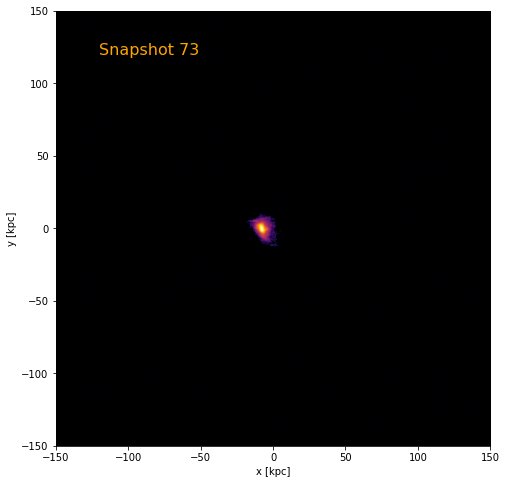

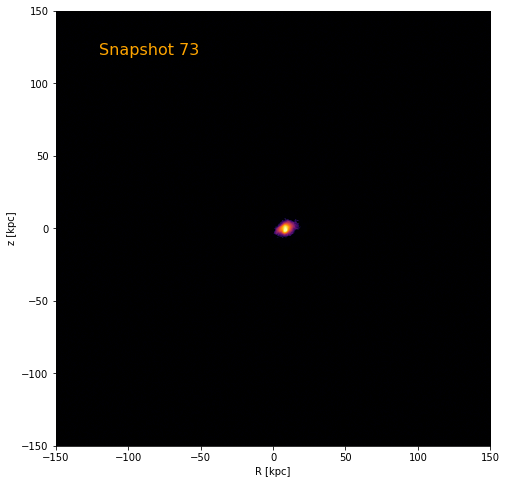

In [15]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black
norm=matplotlib.colors.LogNorm()
s_snap = np.arange(startnr,endnr,1)

### for xy plot ###
X = x_mergers[0]
Y = y_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



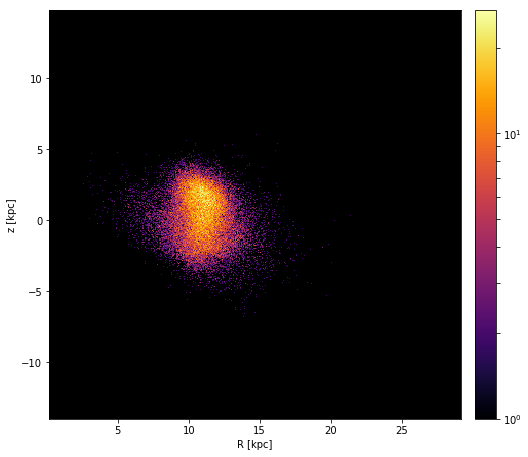

In [64]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
h = ax.hist2d(rxy2_merg_kpc, z2_merg_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [ ]:
s_snap = np.arange(startnr,endnr,1)

fig, ax = plt.subplots(figsize = (8,8))

data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']


figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            

#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



In [ ]:
# schau die animationsdokumentation genauer an um zu sehen was ich wann einlesen muss und worueber gelooped werden muss
# entweder save as files oder finde einen anderen weg, wie ich die ids kriege 
def plot_action_corner():
    

In [ ]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*

### ____ fit actions to stars so only load type 4 ____

level = 4

startnr = 72 # nr of snapshot where dwarf is first merged

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startnr,128,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        '''
        if j == 0:
            # initialize figure if not given as input
            j +=1
        else:
        '''

number of all selected GCs 2648 num of GCs within 50kpc: 1365
number of all selected GCs 9785 num of GCs within 50kpc: 5006


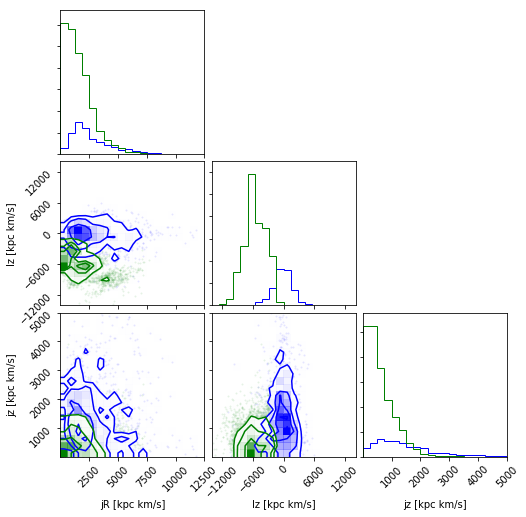

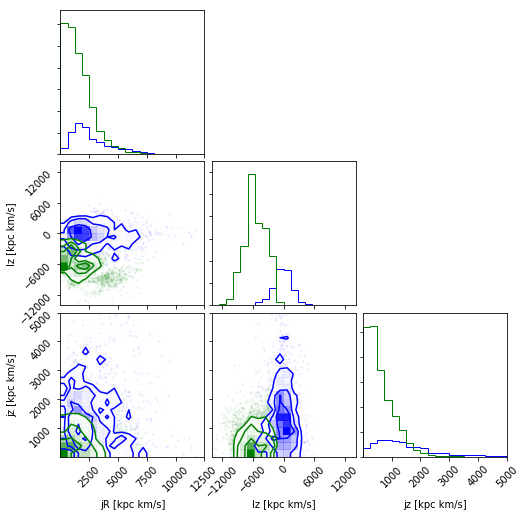

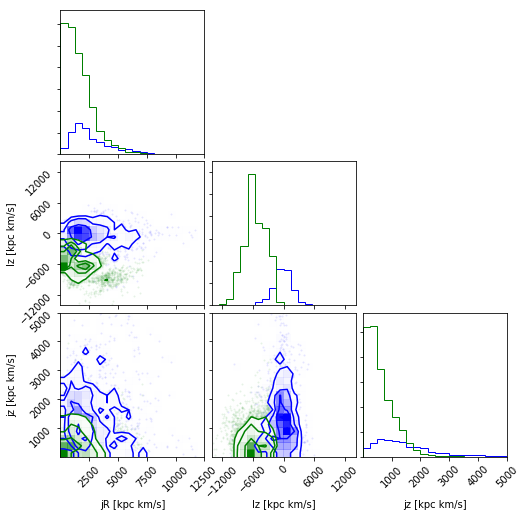

In [6]:
### write a function out of the routine above
# read in ID lists generated in notebook 2dwarf

#def 

org_dwarfs = ['67', '73']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''

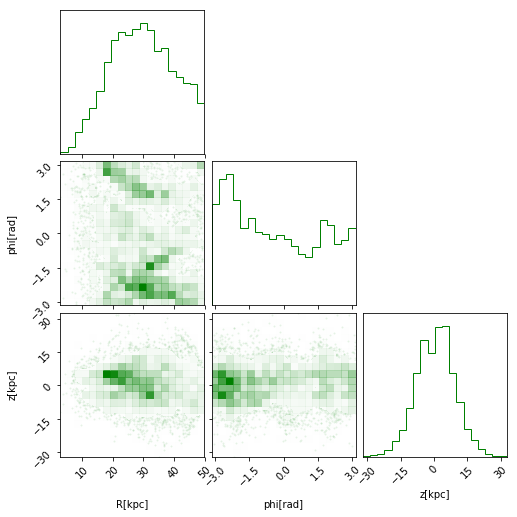

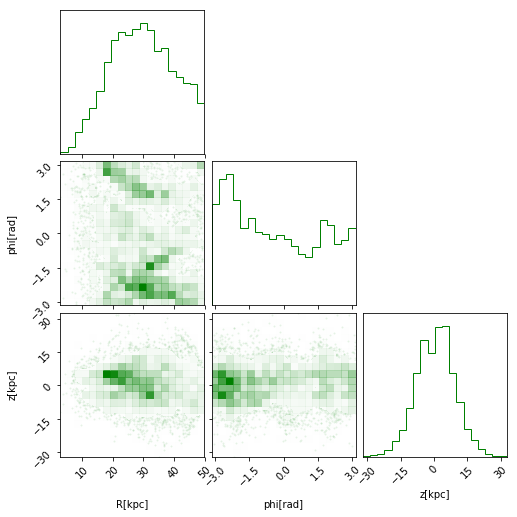

In [8]:
data = np.vstack([R_kpc[r_condition], phi_rad[r_condition], z_kpc[r_condition]])
labels = ['R[kpc]', 'phi[rad]', 'z[kpc]']
corner.corner(data.transpose(), labels = labels, plot_contours = 0, color = color)

number of all selected GCs 2648 num of GCs within 50kpc: 1365
number of all selected GCs 9785 num of GCs within 50kpc: 5006


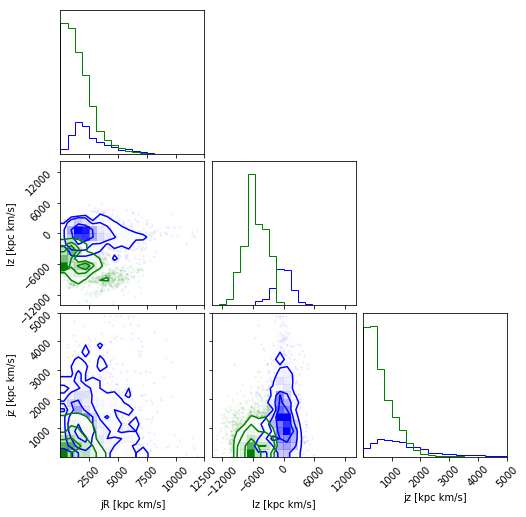

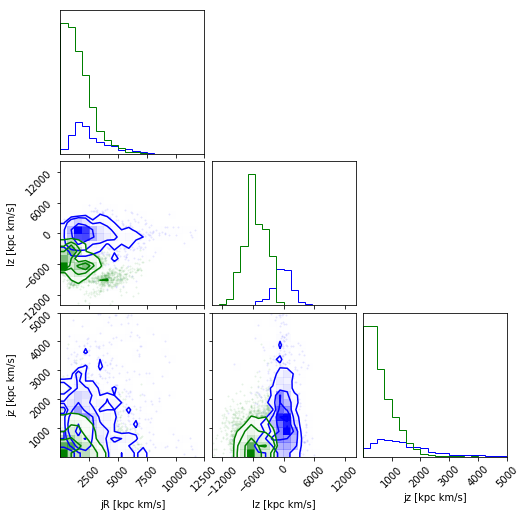

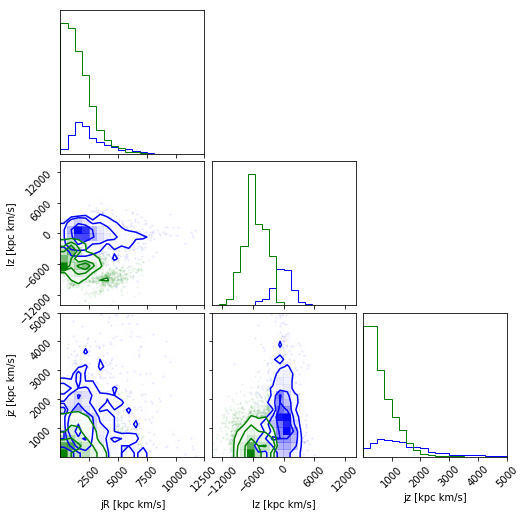

In [7]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['67', '73']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''